In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from uszipcode import SearchEngine
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [13]:
df = pd.read_csv('data/rollingsales_bronx.csv',sep=';')

In [14]:
df.columns[df.isna().any()].tolist()
print(df.columns)

Index([u'BOROUGH', u'NEIGHBORHOOD', u'BUILDING CLASS CATEGORY',
       u'TAX CLASS AT PRESENT', u'BLOCK', u'LOT', u'EASE-MENT',
       u'BUILDING CLASS AT PRESENT', u'ADDRESS', u'APARTMENT NUMBER',
       u'ZIP CODE', u'RESIDENTIAL UNITS', u'COMMERCIAL UNITS', u'TOTAL UNITS',
       u'LAND SQUARE FEET', u'GROSS SQUARE FEET', u'YEAR BUILT',
       u'TAX CLASS AT TIME OF SALE', u'BUILDING CLASS AT TIME OF SALE',
       u' SALE PRICE ', u'SALE DATE'],
      dtype='object')


In [15]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index([u'BOROUGH', u'NEIGHBORHOOD', u'BUILDING_CLASS_CATEGORY',
       u'TAX_CLASS_AT_PRESENT', u'BLOCK', u'LOT', u'EASE-MENT',
       u'BUILDING_CLASS_AT_PRESENT', u'ADDRESS', u'APARTMENT_NUMBER',
       u'ZIP_CODE', u'RESIDENTIAL_UNITS', u'COMMERCIAL_UNITS', u'TOTAL_UNITS',
       u'LAND_SQUARE_FEET', u'GROSS_SQUARE_FEET', u'YEAR_BUILT',
       u'TAX_CLASS_AT_TIME_OF_SALE', u'BUILDING_CLASS_AT_TIME_OF_SALE',
       u'_SALE_PRICE_', u'SALE_DATE'],
      dtype='object')

In [16]:
#Dropping very sparse columns with potentially little info
df = df.drop(['EASE-MENT','APARTMENT_NUMBER'],axis=1)

In [17]:
#Dropping houses with missing price
df = df[df['_SALE_PRICE_'] != " $-   "]

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],format='%d/%m/%Y')
df['_SALE_PRICE_'] = df['_SALE_PRICE_'].apply(lambda x:int(x.replace(' ','').replace('$','')))
df['year'] = df['SALE_DATE'].apply(lambda x:x.year)
df['month'] = df['SALE_DATE'].apply(lambda x:x.month)
df['weekday'] = df['SALE_DATE'].apply(lambda x:x.weekday())

In [18]:
df.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,_SALE_PRICE_,year,month,weekday
count,5693.0,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5693.000000,5.693000e+03,5693.000000,5693.000000,5693.000000
mean,2.0,4226.736167,346.161075,10392.417706,2.564729,0.113297,2.680133,2588.111014,2896.847883,1766.896188,1.496223,8.126878e+05,2017.824346,6.590198,2.125242
std,0.0,1068.711814,835.322720,863.214225,8.189745,0.685653,8.279025,4867.143153,9607.317885,560.348595,0.746880,2.960207e+06,0.380559,3.422953,1.397072
min,2.0,2263.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,2017.000000,1.000000,0.000000
25%,2.0,3295.000000,23.000000,10461.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1920.000000,1.000000,2.250000e+05,2018.000000,4.000000,1.000000
50%,2.0,4174.000000,50.000000,10465.000000,1.000000,0.000000,1.000000,2167.000000,1690.000000,1931.000000,1.000000,4.390000e+05,2018.000000,7.000000,2.000000
75%,2.0,5095.000000,135.000000,10469.000000,2.000000,0.000000,2.000000,2774.000000,2624.000000,1960.000000,2.000000,6.400000e+05,2018.000000,9.000000,3.000000
max,2.0,5957.000000,5294.000000,10475.000000,189.000000,24.000000,190.000000,127721.000000,352866.000000,2018.000000,4.000000,1.254000e+08,2018.000000,12.000000,6.000000


In [19]:
#Not sure whether land/gross square feet = 0 is possible
print(df[df['GROSS_SQUARE_FEET']==0].shape)
print(df[df['LAND_SQUARE_FEET']==0].shape)

(1863, 22)
(1705, 22)


In [20]:
def clean_df(filename):
    
    df = pd.read_csv('data/'+filename,sep=';')
    df.columns = df.columns.str.replace(' ','_')
    #Dropping very sparse columns
    df = df.drop(['EASE-MENT','APARTMENT_NUMBER'],axis=1)
    
    #Dropping houses with missing price
    df = df[df['_SALE_PRICE_'] != " $-   "]
        
    #Turn Sale price column in numerical data
    df['_SALE_PRICE_'] = df['_SALE_PRICE_'].apply(lambda x:int(x.replace(' ','').replace('$','')))
    df['_SALE_PRICE_']=df['_SALE_PRICE_'].astype('int64')
    
    #Extract year/month/weekday and drop data column
    df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],format='%d/%m/%Y')
    
    #We keep year as a numerical feature (maybe not enough data to use as categorical)
    df['year'] = df['SALE_DATE'].apply(lambda x:x.year)
    
    #Month and weekday as categorical
    df['month'] = df['SALE_DATE'].apply(lambda x:x.month).astype('category')
    df['weekday'] = df['SALE_DATE'].apply(lambda x:x.weekday()).astype('category')
    
    df['TAX_CLASS_AT_TIME_OF_SALE'] = df['TAX_CLASS_AT_TIME_OF_SALE'].astype('category')
    
    # PROCESSING THE ZIPCODE FEATURE
    search = SearchEngine(simple_zipcode=True)
    
    
    #We enrich data with values coming from uszipcode
    for i in df.index:
        
        zipcode = search.by_zipcode(df.loc[i,'ZIP_CODE'])
        zipdict = zipcode.to_dict()
        df.loc[i,'median_home_value'] = zipdict['median_home_value']
        df.loc[i,'median_household_income']=zipdict['median_household_income']
        df.loc[i,'occupied_housing_units'] =zipdict['occupied_housing_units']
        df.loc[i,'population_density'] =  zipdict['population_density']
    
    df = df.drop(['SALE_DATE'],axis=1)
    #Dropping address column
    df = df.drop(['ADDRESS'],axis=1)
    #Dropping lot feature (related to borough feature)
    df = df.drop(['LOT'],axis=1)
    #Dropping block feature (related to borough feature)
    df = df.drop(['BLOCK'],axis=1)
    
    
    return df
    

In [21]:
#Processing and Concatenating all the dataframes
df1 = clean_df('rollingsales_bronx.csv')
df2 = clean_df('rollingsales_brooklyn.csv')
df3 = clean_df('rollingsales_manhattan.csv')
df4 = clean_df('rollingsales_queens.csv')
df5 = clean_df('rollingsales_statenisland.csv')

df=pd.concat([df1,df2,df3,df4,df5])
df.shape

(57685, 22)

In [22]:
print(df._get_numeric_data().columns)
print(df.shape)

Index([u'BOROUGH', u'ZIP_CODE', u'RESIDENTIAL_UNITS', u'COMMERCIAL_UNITS',
       u'TOTAL_UNITS', u'LAND_SQUARE_FEET', u'GROSS_SQUARE_FEET',
       u'YEAR_BUILT', u'_SALE_PRICE_', u'year', u'median_home_value',
       u'median_household_income', u'occupied_housing_units',
       u'population_density'],
      dtype='object')
(57685, 22)


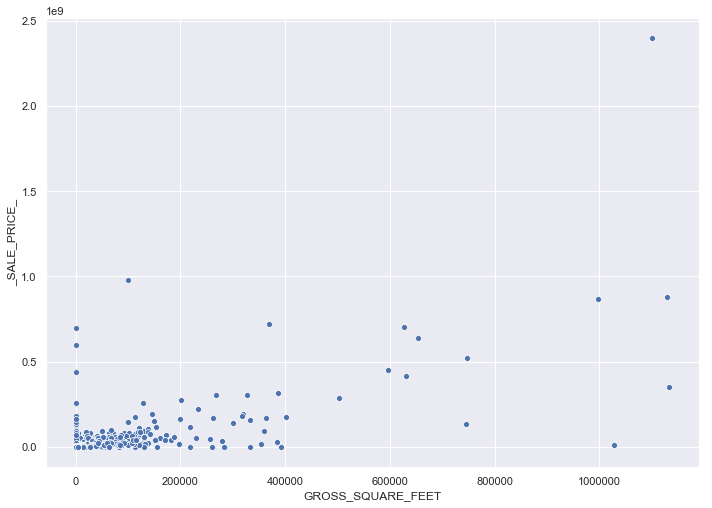

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='GROSS_SQUARE_FEET',y='_SALE_PRICE_',data=df)

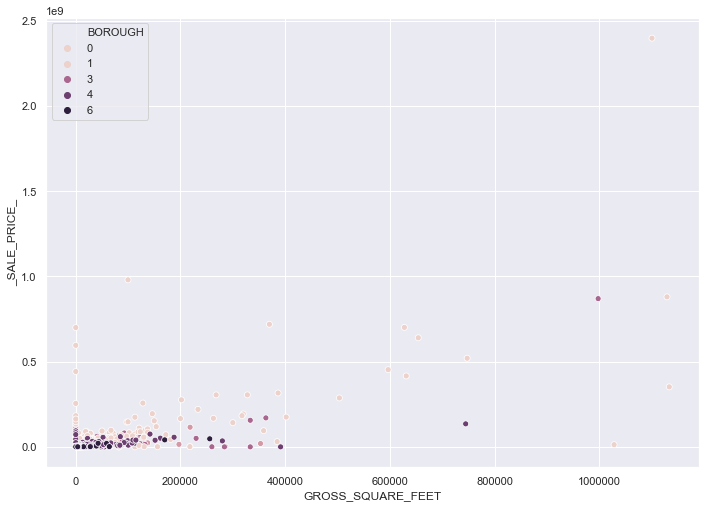

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='GROSS_SQUARE_FEET',y='_SALE_PRICE_',hue='BOROUGH',data=df)

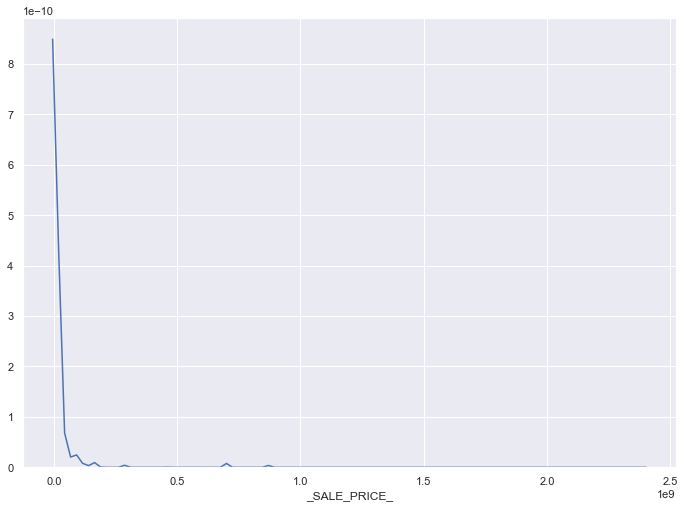

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['_SALE_PRICE_'],hist=False)

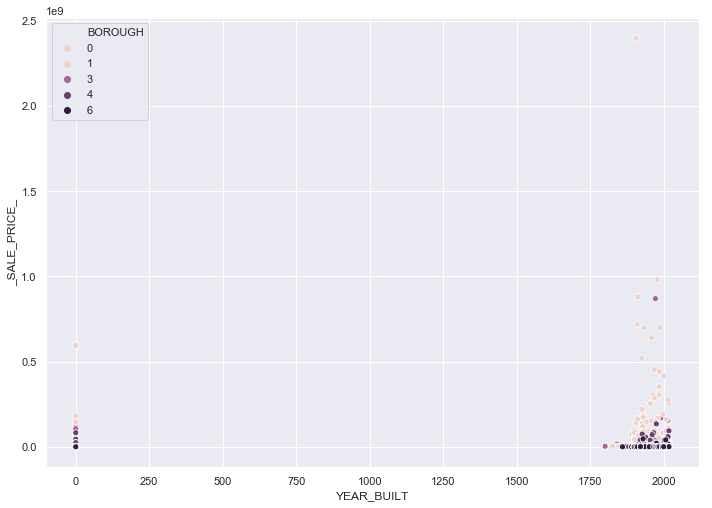

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='YEAR_BUILT',y='_SALE_PRICE_',hue='BOROUGH',data=df)

In [27]:
# Null value for year_built
print(df.loc[df['YEAR_BUILT']==0].shape)
df = df.loc[df['YEAR_BUILT']!=0]

(3661, 22)


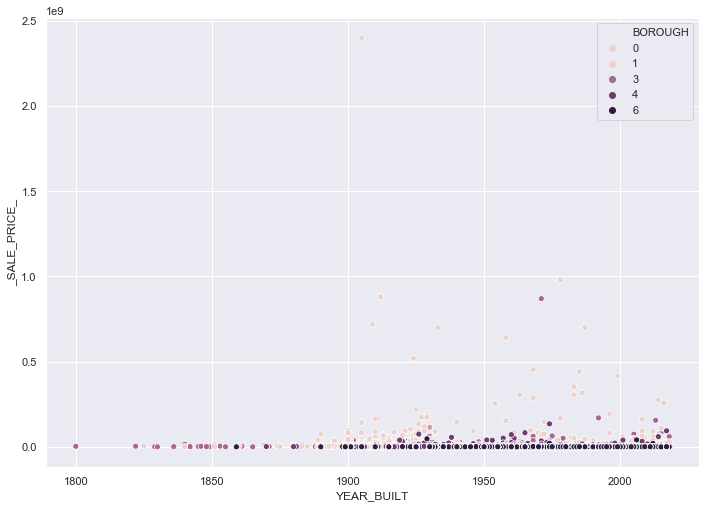

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='YEAR_BUILT',y='_SALE_PRICE_',hue='BOROUGH',data=df)

In [31]:
df.loc[df['_SALE_PRICE_']==0].shape

(0, 22)

In [32]:
#Very high number of null square feet for gross and land square feet
#It might be due to the fact that apartments are getting a 0 value (in comparison with houses)
#Therefore, we keep those rows in the dataset
print(df[df['GROSS_SQUARE_FEET']==0].shape)
print(df[df['LAND_SQUARE_FEET']==0].shape)

(24992, 22)
(24685, 22)


In [17]:
#600 columns with NaN values in the coordinates features
df = df.dropna()
df.shape

(53737, 22)

In [18]:
scaler = StandardScaler()
df[df._get_numeric_data().columns] = scaler.fit_transform(df[df._get_numeric_data().columns]) 

print(df.shape)


(53737, 22)


In [19]:
#Creating the dummy variables
df = pd.get_dummies(df)
print(df.shape)

(53737, 646)


In [20]:
#Saving the dataset to csv
df.to_csv('data/merged_df.csv')